In [1]:
%matplotlib inline

# lkprf Basics

## Author
Nicole Schanche - TESS Science Support Center

## Tutorial Goals

Light from sources does not fall cleanly on a single pixel. Instead, the light is distributed across an area of the detector, known as the Point Spread Function (PSF). The PSF is not constant and varies as a function of spacecraft motion, jitter, location on the detector plane, and detector response. Both [Kepler](https://archive.stsci.edu/missions/kepler/commissioning_prfs/) and [TESS](https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/) have measured the PSF of discrete locations on the CCD in order to model the observed light contribution of a source across the pixels (the Pixel Response Function or PRF). To learn more about the PRF measurements, you can refer to [this paper](https://arxiv.org/pdf/1001.0331).


In this notebook, we demonstrate how to use lkprf to generate a PRF model based on these engineering files. We will create our PRF for a source observed in a real Target Pixel File (TPF). 

## Imports

This tutorial makes use of a number of packages including [matplotlib](https://matplotlib.org/), [numpy](https://numpy.org/), and [astropy](https://www.astropy.org/). In addition it utilized the [lksearch](https://github.com/lightkurve/lksearch) package, which is designed to search for and download data from the TESS and Kepler/K2 missions. 

In [2]:
import matplotlib.pyplot as plt
import lkprf
import lksearch
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits

## Step 1: Get a TPF

In this notebook, we will try to recreate the PRF of a real observed star. To do this, we will start by getting the Target Pixel File for a relatively isolated (low contamination) star. We limit the search using `pipeline='SPOC'`, which restricts the search results to files produced by the mission pipeline. As we want to model a PRF, we further restrict data to target pixel files, known generically as 'cubedata' in the lksearch package. For more information on formulating searches, you can check out [this tutorial](https://github.com/lightkurve/lksearch/blob/main/docs/tutorials/Example_searches.ipynb). 

In [3]:
sr = lksearch.TESSSearch('Kepler 50', pipeline='SPOC').cubedata
sr


,target_name,pipeline,mission,sector,exptime,distance,year,description
0,298896336,SPOC,TESS,26,120.0,0.0,2020,Target pixel files
1,298896336,SPOC,TESS,40,20.0,0.0,2021,Target pixel files
2,298896336,SPOC,TESS,40,120.0,0.0,2021,Target pixel files
3,298896336,SPOC,TESS,41,20.0,0.0,2021,Target pixel files
4,298896336,SPOC,TESS,41,120.0,0.0,2021,Target pixel files
...,...,...,...,...,...,...,...,...
9,298896336,SPOC,TESS,55,20.0,0.0,2022,Target pixel files
10,298896336,SPOC,TESS,55,120.0,0.0,2022,Target pixel files
11,298896336,SPOC,TESS,74,120.0,0.0,2024,Target pixel files
12,298896336,SPOC,TESS,75,120.0,0.0,2024,Target pixel files


The search result contains a table showing all of the observations of the target for which SPOC data is available to download. The exptime column indicates the observing cadence by TESS. In this case, the star was in some sectors observed in high cadence (20-second) model. 

The model TPF will be different for this target for every observing sector, as the target will fall on different pixels and different camera and CCDs. Let's just pick a single sector to model. In the download command below, we specify the 0th element of the table, corresponding to the 120-second cadence TPF from sector 26. 

In [4]:
fnames = sr[0].download()
fnames


pipeline products: 100%|██████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


,Local Path,Status,Message,URL
0,/Users/nthom/.lksearch/cache/mastDownload/TESS...,COMPLETE,None,None


Note lksearch will download the data and return a dataframe containing the local file path it is downloaded to.  However, it does not read it in to a lightkurve object. We will read it in using the fits file handling package in astropy. If you need a refresher on fits file handling, you can see this [astropy tutorial](https://learn.astropy.org/tutorials/FITS-images.html). 

In [5]:
tess_hdulist = fits.open(fnames['Local Path'].values[0])

## Step 2: Create a PRF model

Now that we have our file, we can set up our PRF model. 
To initiate a PRF object, we need to know which camera and CCD (TESS) or channel (Kepler) the target is on. We also can optionally provide the observing Sector for TESS. This is because two sets of PRF engineering models were produced for TESS. The first models were made during commissioning and are used for the early sectors (Sectors 1-3). The commissioning observations were re-run after Sector 3, and these files can be used for subsequent TESS sectors. If the sector is not specified, the models produced for sectors 4 onwards are used. 

In [6]:
camera = tess_hdulist[0].header['CAMERA']
ccd = tess_hdulist[0].header['CCD']
sector = tess_hdulist[0].header['SECTOR'] 


# initialize the PRF object
prf_initial = lkprf.TESSPRF(camera=camera, ccd=ccd) #, sector=sector) 

To produce the model itself, we need three pieces of information:
- the origin of the cutout (lower left corner),
- the target object location
- the size of the cutout

All of this information can be found in the header information containing in the TPF file. We will use the WCS information contained in the TPF to determine the pixel location of the target. Note that this location is based on the J2000 coordinates, so the location may need to be updated for high proper motion targets. 

In [7]:
origin_row =  tess_hdulist[1].header['2CRV4P'] 
origin_col =  tess_hdulist[1].header['1CRV4P'] 


# get the WCS information
wcs = WCS(tess_hdulist[2].header)
# Convert the RA/Dec of the object into pixel coordinates. 
wcs_pix = wcs.all_world2pix(tess_hdulist[0].header['RA_OBJ'] , tess_hdulist[0].header['DEC_OBJ'],0)
wcs_col = wcs_pix[0]
wcs_row = wcs_pix[1]

# The wcs_row and wcs_col values are in realtive pixels for the cutout, not the CCD as a whole.
# We need to add the origin row and column to find the target pixel location on the CCD
target_col = origin_col + wcs_col
target_row = origin_row + wcs_row

shape = tess_hdulist[1].data['FLUX'].shape[1:]


Now we have everything we need to create the model. Note the output shape. The first dimension is the number of targets. In this case, we are only modeling a single target, but in practice you may want to model every star contained in the TPF. 

In [8]:
model_prf = prf_initial.evaluate(targets=[(target_row, target_col)], origin=(origin_row, origin_col), shape=shape)
model_prf.shape

(1, 11, 11)

## Step 3: Visualize the PRF model

Great! We've created a model of the TPF. Let's plot the model to see how it looks compared to the TPF data. 

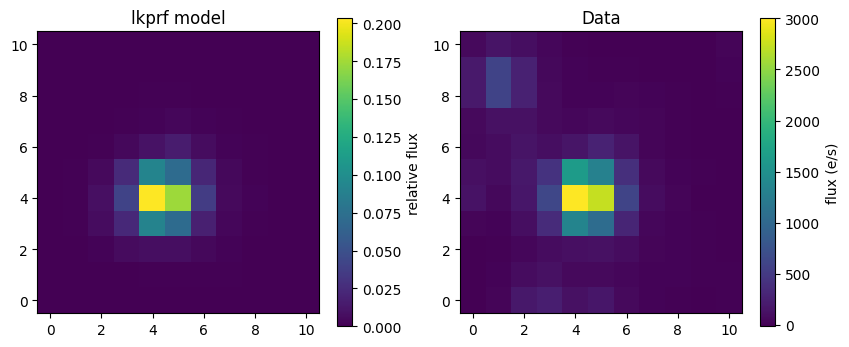

In [9]:
fig,axs = plt.subplots(1,2,figsize=(10,4))


model = axs[0].imshow(model_prf[0,:,:], origin='lower')
axs[0].set_title('lkprf model')
fig.colorbar(model, ax = axs[0], label='relative flux')

# Plot the real data. We randomly select the 100th observation from the TPF data cube
data = axs[1].imshow(tess_hdulist[1].data['FLUX'][100,:,:],  origin='lower')
axs[1].set_title('Data')
fig.colorbar(data, ax = axs[1], label = 'flux (e/s)')

plt.show()


This looks like a good match! It is clear that the real data does in fact have a few other sources of flux, but overall the modeled PRF matches the observations of the primary star. Let's scale the data a bit so we see the comparison more clearly. 

*Note we add some error handling here. The model contains zero values where no flux is expected, which is invalid when taking the log of the value. 

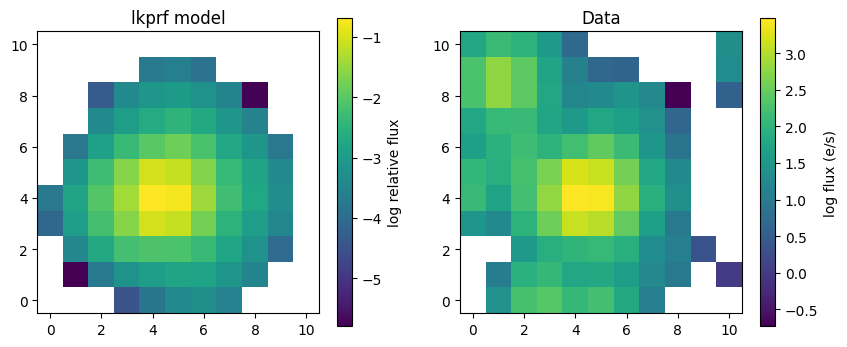

In [10]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

# Supress warnings due to taking log of 0. These pixels will be nans, and display as white. 
with np.errstate(invalid='ignore', divide='ignore'):
    model = axs[0].imshow(np.log10(model_prf[0,:,:]), origin='lower')
axs[0].set_title('lkprf model')
fig.colorbar(model, ax = axs[0], label='log relative flux')

# Supress warnings due to taking log of 0. These pixels will be nans, and display as white. 
with np.errstate(invalid='ignore'):
    data = axs[1].imshow(np.log10(tess_hdulist[1].data['FLUX'][100,:,:]),  origin='lower')
axs[1].set_title('Data')
fig.colorbar(data, ax = axs[1], label = 'log flux (e/s)')

plt.show()

## Create a PRF model for Kepler
Great! Now let's check out the same target with Kepler. We follow the same steps as above to initialize our PRF object and evaluate the model at the target location.

pipeline products: 100%|██████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


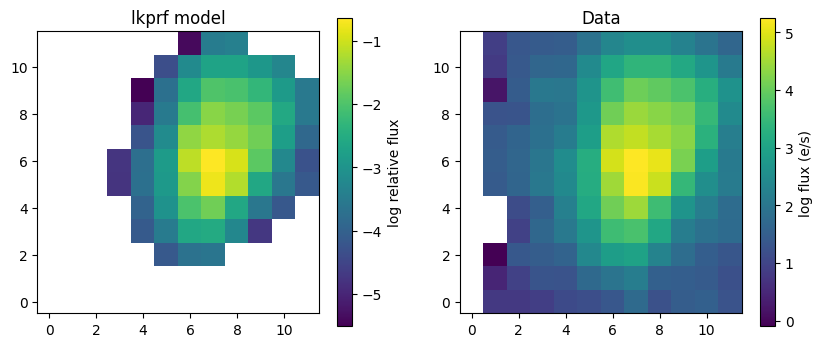

In [11]:
fnames = lksearch.KeplerSearch('Kepler 50').cubedata[0].download()
kepler_hdulist = fits.open(fnames['Local Path'].values[0])
channel = kepler_hdulist[0].header['CHANNEL']

# initialize the PRF object
prf_initial = lkprf.KeplerPRF(channel=channel) 

origin_row =  kepler_hdulist[1].header['2CRV4P'] 
origin_col =  kepler_hdulist[1].header['1CRV4P'] 


# get the WCS information
wcs = WCS(kepler_hdulist[2].header)
# Convert the RA/Dec of the object into pixel coordinates. 
wcs_pix = wcs.all_world2pix(kepler_hdulist[0].header['RA_OBJ'] , kepler_hdulist[0].header['DEC_OBJ'],0)
wcs_col = wcs_pix[0]
wcs_row = wcs_pix[1]

target_col = origin_col + wcs_col
target_row = origin_row + wcs_row

shape = kepler_hdulist[1].data['FLUX'].shape[1:]


# Evaluate the model at our target position
model_prf = prf_initial.evaluate(targets=[(target_row, target_col)], origin=(origin_row, origin_col), shape=shape)



# Plot the results
fig,axs = plt.subplots(1,2,figsize=(10,4))

# Supress warnings due to taking log of 0. These pixels will be nans, and display as white. 
with np.errstate(invalid='ignore', divide='ignore'):
    model = axs[0].imshow(np.log10(model_prf[0,:,:]), origin='lower')
axs[0].set_title('lkprf model')
fig.colorbar(model, ax = axs[0], label='log relative flux')

with np.errstate(invalid='ignore'):
    data = axs[1].imshow(np.log10(kepler_hdulist[1].data['FLUX'][100,:,:]),  origin='lower')
axs[1].set_title('Data')
fig.colorbar(data, ax = axs[1], label = 'log flux (e/s)')

plt.show()

Excellent! This is also looks like a good match to the Kepler observations. 

## Conclusion

While the shape of the PRF looks correct, it is important to remember that the PRF model contains the relative contribution of the pixels and not the flux values (in electrons per second) that we see in the observations. To match the flux values seen in a TPF, you would want to multiply the PRF by the expected flux of the target. 